<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [48]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from iterativennsimple.MaskedLinear import MaskedLinear
from generatedata.load_data import load_data
from generatedata.StartTargetData import StartTargetData

In [49]:
#name = 'circle'
name = 'MNIST'
#name = 'EMlocalization'
#name = 'LunarLander'

data_dict = load_data('MNIST')
# Read the start data
x_start = data_dict['start']
# Read the target data
x_target = data_dict['target']


# Dynamical system

In [50]:
x_size = x_start.shape[1]
padding_size = 100
z_size = x_size+padding_size
test_size = 500

This is the multiplicative fish that we derive in notebooks/develop/01-rcp-simple-fish.ipynb

It is:

$$
(W_1 \cdot x + b_1) \odot (W_2 \cdot x + b_2)
$$

In [51]:
class MultiplicativeFish(nn.Module):
    def __init__(self, W1, b1, W2, b2):
        super().__init__()
        self.W1 = W1
        self.b1 = torch.nn.Parameter(b1)    
        self.W2 = W2
        self.b2 = torch.nn.Parameter(b2)

    def forward(self, x):
        return (self.W1(x) + self.b1) * (self.W2(x) + self.b2)

    @staticmethod
    def get_identity(z_size):
        # Create a MultiplicativeFish that is the identity function
        W1 = MaskedLinear.from_description([z_size], [z_size], block_types=[['D']], initialization_types=[[1]], trainable=[[True]], bias=False)
        b1 = torch.zeros(z_size, requires_grad=True)
        W2 = MaskedLinear.from_description([z_size], [z_size], block_types=[['D']], initialization_types=[[0]], trainable=[[True]], bias=False) 
        b2 = torch.ones(z_size, requires_grad=True)
        return MultiplicativeFish(W1, b1, W2, b2) 

    @staticmethod
    def get_random(z_size):
        # Create a MultiplicativeFish that is the identity function
        W1 = MaskedLinear.from_description([z_size], [z_size], block_types=[['W']], initialization_types=[['G=0.0,0.01']], trainable=[[True]], bias=False)
        b1 = torch.zeros(z_size, requires_grad=True)
        W2 = MaskedLinear.from_description([z_size], [z_size], block_types=[['W']], initialization_types=[['G=0.0,0.01']], trainable=[[True]], bias=False) 
        b2 = torch.ones(z_size, requires_grad=True)
        return MultiplicativeFish(W1, b1, W2, b2) 


This is the discontinuous fish that we derive in notebooks/develop/01-rcp-simple-fish.ipynb

It is:

$$
f(x) = 
\begin{cases}
    W_1 \cdot x + b_1 & \text{if } x_j < 0 \\
    W_2 \cdot x + b_2 & \text{else}
\end{cases}
$$

In [52]:
class DiscontinuousFish(nn.Module):
    def __init__(self, W1, b1, W2, b2):
        super().__init__()
        self.W1 = W1
        self.b1 = torch.nn.Parameter(b1)    
        self.W2 = W2
        self.b2 = torch.nn.Parameter(b2)

    def forward(self, x):
        return torch.where(x < 0, self.W1(x) + self.b1, self.W2(x) + self.b2)
    
    @staticmethod
    def get_identity(z_size):
        # Create a DiscontinuousFish that is the identity function
        W1 = MaskedLinear.from_description([z_size], [z_size], block_types=[['D']], initialization_types=[[1]], trainable=[[True]], bias=False)
        b1 = torch.zeros(z_size, requires_grad=True)
        W2 = MaskedLinear.from_description([z_size], [z_size], block_types=[['D']], initialization_types=[[1]], trainable=[[True]], bias=False) 
        b2 = torch.zeros(z_size, requires_grad=True)
        return DiscontinuousFish(W1, b1, W2, b2)   
    
    @staticmethod
    def get_random(z_size):
        # Create a MultiplicativeFish that is the identity function
        W1 = MaskedLinear.from_description([z_size], [z_size], block_types=[['W']], initialization_types=[['G=0.0,0.01']], trainable=[[True]], bias=False)
        b1 = torch.zeros(z_size, requires_grad=True)
        W2 = MaskedLinear.from_description([z_size], [z_size], block_types=[['W']], initialization_types=[['G=0.0,0.01']], trainable=[[True]], bias=False) 
        b2 = torch.ones(z_size, requires_grad=True)
        return MultiplicativeFish(W1, b1, W2, b2) 

Do some unit tests to make sure the two fish do the right things.  This is a good idea

![Alt text](image.png)

I put this here to encourage people to do similiar things in their own code.

In [53]:
def test():
    X = torch.rand(1000, z_size)

    # These should be the identity map, this confirms that the implementation is correct
    with torch.no_grad():
        map = MultiplicativeFish.get_identity(z_size)
        Y = map(X)  
        assert torch.isclose(X, Y).all(), "MultiplicativeFish is not the identity map"

    with torch.no_grad():
        map = DiscontinuousFish.get_identity(z_size)
        Y = map(X)  
        assert torch.isclose(X, Y).all(), "DiscontinuousFish is not the identity map"

    # A slighlyt harder test.  The composition of two identity maps should be the identity map
    with torch.no_grad():
        map1 = MultiplicativeFish.get_identity(z_size)
        map2 = DiscontinuousFish.get_identity(z_size)
        map = torch.nn.Sequential(map1, map2)
        Y = map(X)  
        assert torch.isclose(X, Y).all(), "MultiplicativeFish \circ DiscontinuousFish is not the identity map"

test()

Now we can start actually training the dynamical system.  

In [54]:
# map = DiscontinuousFish.get_identity(z_size)
map = MultiplicativeFish.get_identity(z_size)

# map = MultiplicativeFish.get_random(z_size)


# map1 = MultiplicativeFish.get_identity(z_size)
# map2 = DiscontinuousFish.get_identity(z_size)
# map = torch.nn.Sequential(map1, map2)

map.to('cuda')

MultiplicativeFish(
  (W1): MaskedLinear(in_features=894, out_features=894, bias=False)
  (W2): MaskedLinear(in_features=894, out_features=894, bias=False)
)

In [55]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Make two pytorch tensor datasets from the start and target data
x_start_tensor = df_to_tensor(x_start)
x_target_tensor = df_to_tensor(x_target)

# Pad the tensors with zeros
x_start_tensor = torch.nn.functional.pad(x_start_tensor, (0, padding_size))
x_target_tensor = torch.nn.functional.pad(x_target_tensor, (0, padding_size))

In [56]:

x_start_tensor_test = x_start_tensor[:test_size]
x_target_tensor_test = x_target_tensor[:test_size]

x_start_tensor = x_start_tensor[test_size:]
x_target_tensor = x_target_tensor[test_size:]
    
train_data = StartTargetData(x_start_tensor, x_target_tensor)
test_data = StartTargetData(x_start_tensor_test, x_target_tensor_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=False)

In [57]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.0002)

In [58]:
max_epochs = 1001
max_iterations = 5
losses = torch.zeros(max_epochs, max_iterations)
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        start = start.to('cuda')
        target = target.to('cuda')

        total_loss = 0
        mapped = start
        for i in range(max_iterations):
            mapped = map(mapped)
            tmp_loss = criterion(mapped[:, :x_size], target[:, :x_size])
            losses[epoch, i] = tmp_loss.item()
            total_loss += tmp_loss
            # if name == 'MNIST':
            #     # A version of oracle conditioning for MNIST
            #     # The first 28*28 dimensions are the image which we know and keep fixed.
            #     mapped = torch.concatenate([target[:, :x_size-1], mapped[:, x_size-1:]], dim=1) 

        total_loss.backward()

        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Total Loss {total_loss.item():.2e}')
        for i in range(max_iterations):
            print(f'Iter {i}: {losses[epoch, i]:.2e}', end=', ')
        print()  


Epoch 0, Batch 0, Total Loss 5.67e-03
Iter 0: 1.13e-03, Iter 1: 1.13e-03, Iter 2: 1.13e-03, Iter 3: 1.13e-03, Iter 4: 1.13e-03, 
Epoch 100, Batch 0, Total Loss 7.65e-03
Iter 0: 1.15e-03, Iter 1: 1.33e-03, Iter 2: 1.54e-03, Iter 3: 1.72e-03, Iter 4: 1.91e-03, 
Epoch 200, Batch 0, Total Loss 4.58e-03
Iter 0: 8.02e-04, Iter 1: 9.06e-04, Iter 2: 8.84e-04, Iter 3: 9.97e-04, Iter 4: 9.94e-04, 
Epoch 300, Batch 0, Total Loss 3.03e-03
Iter 0: 5.43e-04, Iter 1: 6.50e-04, Iter 2: 5.46e-04, Iter 3: 6.71e-04, Iter 4: 6.16e-04, 
Epoch 400, Batch 0, Total Loss 2.24e-03
Iter 0: 4.05e-04, Iter 1: 5.09e-04, Iter 2: 3.86e-04, Iter 3: 5.01e-04, Iter 4: 4.41e-04, 
Epoch 500, Batch 0, Total Loss 1.78e-03
Iter 0: 3.33e-04, Iter 1: 4.04e-04, Iter 2: 3.04e-04, Iter 3: 3.89e-04, Iter 4: 3.49e-04, 
Epoch 600, Batch 0, Total Loss 1.46e-03
Iter 0: 2.86e-04, Iter 1: 3.24e-04, Iter 2: 2.51e-04, Iter 3: 3.08e-04, Iter 4: 2.87e-04, 
Epoch 700, Batch 0, Total Loss 1.21e-03
Iter 0: 2.49e-04, Iter 1: 2.61e-04, Iter 2: 2

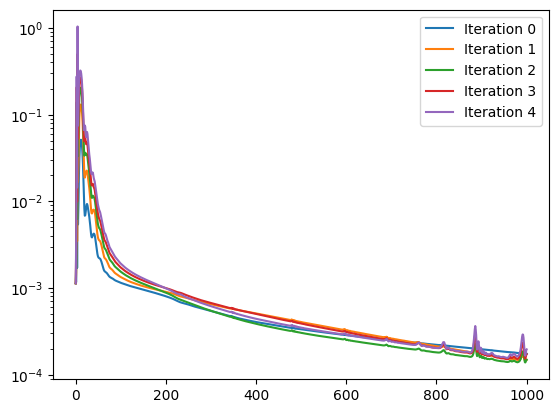

In [59]:
for i in range(max_iterations):
    plt.semilogy(losses[:, i].detach().numpy(), label=f'Iteration {i}')
    plt.legend()    

# Model visualization

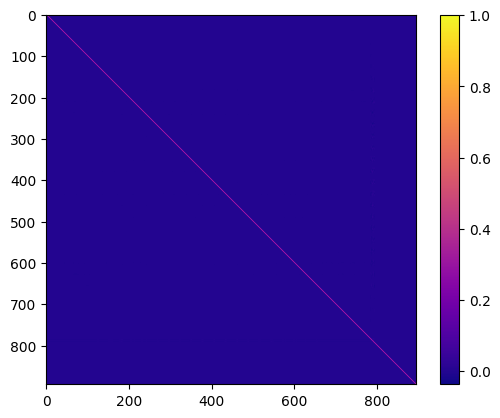

In [60]:
I = torch.eye(z_size).to('cuda')
W1 = map.W1(I).detach().cpu().numpy()
plt.imshow(W1, cmap='plasma')
plt.colorbar()

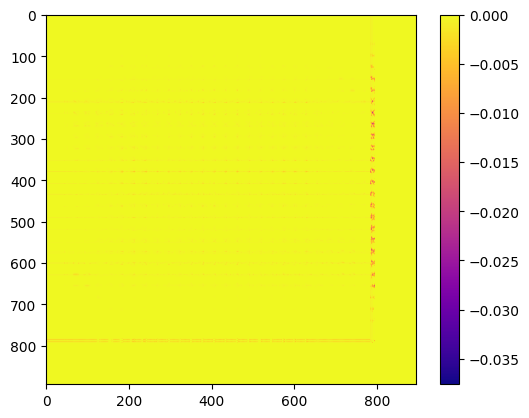

In [61]:
# Plot just the parts of the image where the valye is less than zero
plt.imshow(np.where(W1 < 0, W1, 0), cmap='plasma')
plt.colorbar()

In [62]:
np.where(W1 < -0.5)


(array([], dtype=int64), array([], dtype=int64))

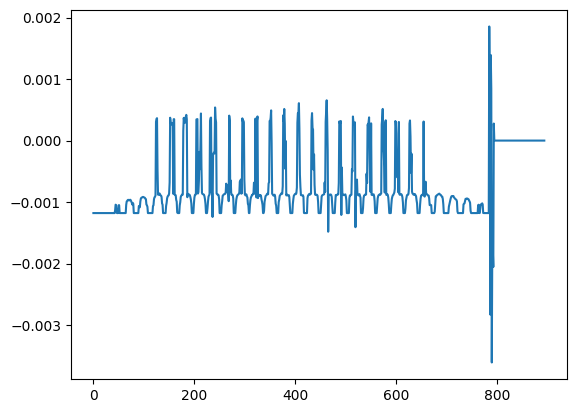

In [63]:
b1 = map.b1.detach().cpu().numpy()
plt.plot(b1)

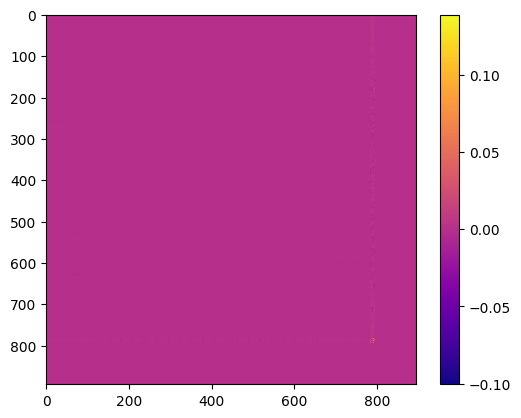

In [64]:
W2 = map.W2(I).detach().cpu().numpy()
plt.imshow(W2, cmap='plasma')
plt.colorbar()

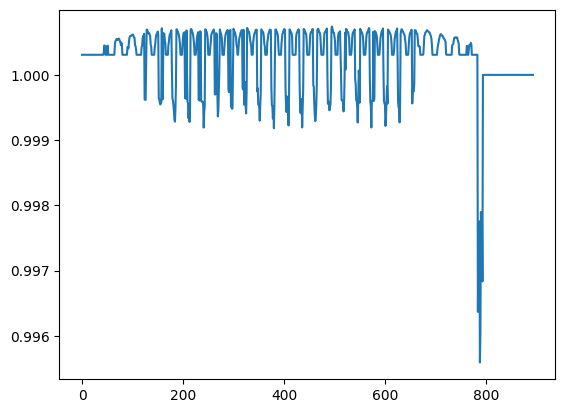

In [65]:
b2 = map.b2.detach().cpu().numpy()
plt.plot(b2)

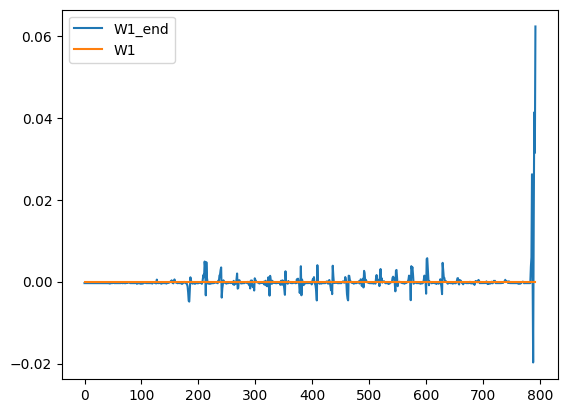

In [66]:
plt.plot(W1[x_size-1, :x_size-1],label='W1_end')
plt.plot(W1[x_size, :x_size-1],label='W1')
plt.legend()


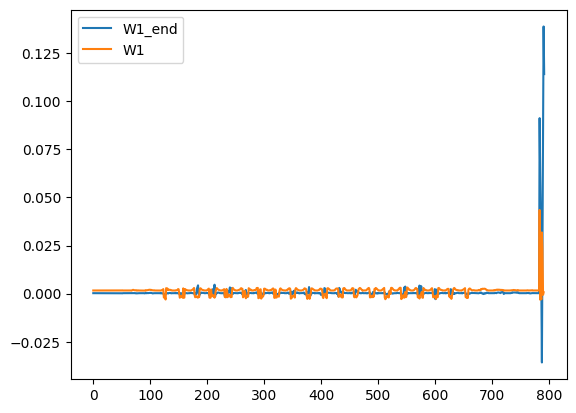

In [67]:
plt.plot(W2[x_size-1, :x_size-1], label='W1_end')
plt.plot(W2[x_size-2, :x_size-2], label='W1')
plt.legend()

# Training data

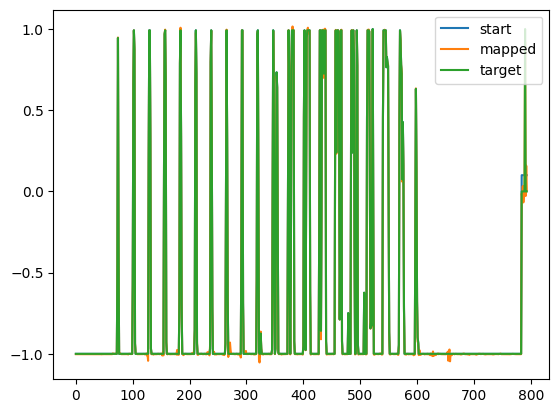

In [68]:
start_batch, target_batch = next(iter(train_loader))
start_batch = start_batch.to('cuda')
target_batch = target_batch.to('cuda')

mapped_batch = start_batch
for i in range(max_iterations):
    mapped_batch = map(mapped_batch)

plot_idx = 0

start_batch = start_batch.to('cpu')
mapped_batch = mapped_batch.to('cpu').detach()
target_batch = target_batch.to('cpu')

plt.plot(start_batch[plot_idx, :x_size],label='start')
plt.plot(mapped_batch[plot_idx, :x_size],label='mapped')
plt.plot(target_batch[plot_idx, :x_size],label='target')
plt.legend()


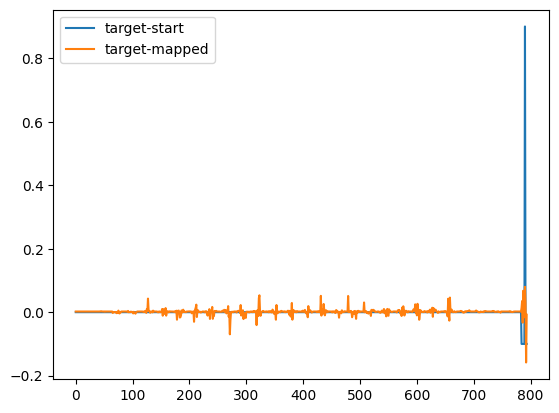

In [69]:
plt.plot(target_batch[plot_idx, :x_size]-start_batch[plot_idx, :x_size], label='target-start')
plt.plot(target_batch[plot_idx, :x_size]-mapped_batch[plot_idx, :x_size], label='target-mapped')
plt.legend()

# Problem specific visualization

tensor(0.1000)
tensor(0.0081)
tensor(0.)
0.10000000149011612 0.008073112927377224 0.0
0.10000000149011612 0.037033531814813614 0.0
0.10000000149011612 -0.07854273915290833 0.0
0.10000000149011612 -0.04913678765296936 0.0
0.10000000149011612 0.04234685003757477 0.0
0.10000000149011612 0.9639825224876404 1.0
0.10000000149011612 -0.02132217399775982 0.0
0.10000000149011612 -0.013460023328661919 0.0
0.10000000149011612 -0.06541679799556732 0.0
0.10000000149011612 -0.012870809063315392 0.0
0.10000000149011612 0.9733796715736389 1.0
0.10000000149011612 -7.980939699336886e-05 0.0
0.10000000149011612 0.029366303235292435 0.0
0.10000000149011612 0.04686800763010979 0.0
0.10000000149011612 -0.013608677312731743 0.0
0.10000000149011612 0.004264291375875473 0.0
0.10000000149011612 -0.11369532346725464 0.0
0.10000000149011612 0.11411567032337189 0.0
0.10000000149011612 0.0022534597665071487 0.0
0.10000000149011612 0.01609627529978752 0.0
0.10000000149011612 -0.007648583501577377 0.0
0.1000000014901

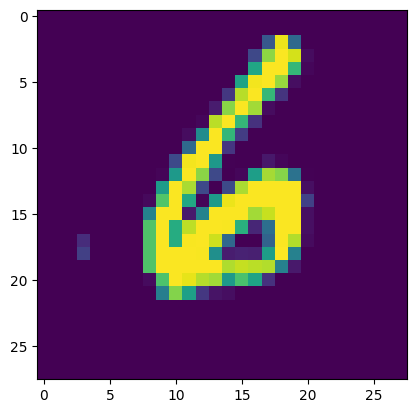

In [70]:
if name == "MNIST":
    plt.imshow(start_batch[plot_idx, :28*28].reshape(28, 28))
    plt.imshow(mapped_batch[plot_idx, :28*28].reshape(28, 28))
    plt.imshow(target_batch[plot_idx, :28*28].reshape(28, 28))

    print(start_batch[plot_idx, x_size-1])
    print(mapped_batch[plot_idx, x_size-1])
    print(target_batch[plot_idx, x_size-1])

    for i in range(start_batch.shape[0]):
        print(f'{start_batch[i, x_size-1]} {mapped_batch[i, x_size-1]} {target_batch[i, x_size-1]}')

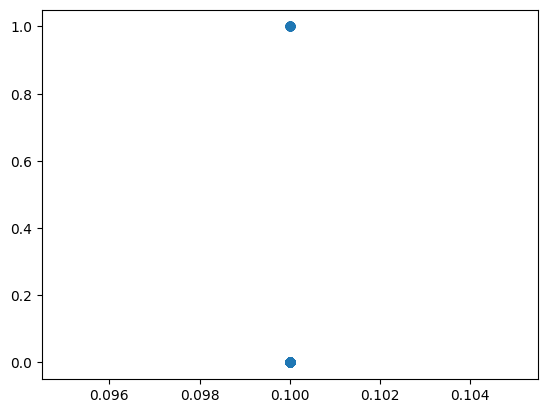

In [71]:
if name == "MNIST":
    y_hat = start_batch[:, x_size-1]
    y = target_batch[:, x_size-1]
    plt.scatter(y_hat, y)

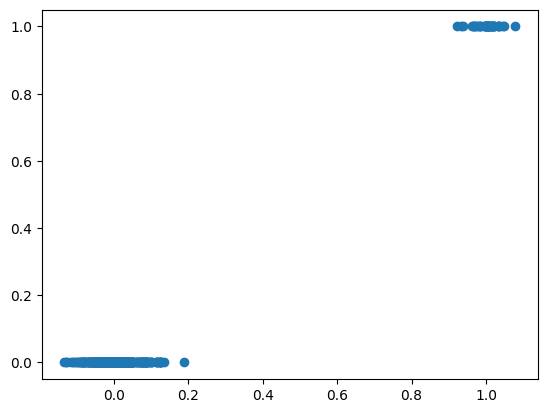

In [72]:
if name == "MNIST":
    y_hat = mapped_batch[:, x_size-1]
    y = target_batch[:, x_size-1]
    plt.scatter(y_hat, y)

In [73]:
if name == 'circle':
    plt.scatter(target_batch[:, 0], target_batch[:, 1], label='target')
    plt.scatter(mapped_batch[:, 0], mapped_batch[:, 1], label='mapped')
    plt.scatter(start_batch[:, 0], start_batch[:, 1], label='start')

In [74]:
if name == 'LunarLander':
    plot_idx = 3
    plt.plot(start_batch[plot_idx, 0:101], start_batch[plot_idx, 101:202], 'o-', label='start')
    plt.plot(mapped_batch[plot_idx, 0:101], mapped_batch[plot_idx, 101:202], 'o-', label='mapped')
    plt.plot(target_batch[plot_idx, 0:101], target_batch[plot_idx, 101:202], 'o-', label='target')
    plt.legend()



# Testing

In [75]:
test_start_batch, test_target_batch = next(iter(test_loader))
test_start_batch = test_start_batch.to('cuda')
test_target_batch = test_target_batch.to('cuda')

test_mapped_batch = test_start_batch
for i in range(5):
    test_mapped_batch = map(test_mapped_batch)

test_start_batch = test_start_batch.to('cpu')
test_mapped_batch = test_mapped_batch.to('cpu').detach()
test_target_batch = test_target_batch.to('cpu')

In [76]:
if name == "MNIST":
    plt.imshow(test_start_batch[plot_idx, :(x_size-1)].reshape(28, 28))
    plt.imshow(test_mapped_batch[plot_idx, :(x_size-1)].reshape(28, 28))
    plt.imshow(test_target_batch[plot_idx, :(x_size-1)].reshape(28, 28))

    print(test_start_batch[plot_idx, x_size-1])
    print(test_mapped_batch[plot_idx, x_size-1])
    print(test_target_batch[plot_idx, x_size-1])

    for i in range(test_start_batch.shape[0]):
        print(f'{test_start_batch[i, x_size-1]} {test_mapped_batch[i, x_size-1]} {test_target_batch[i, x_size-1]}')

RuntimeError: shape '[28, 28]' is invalid for input of size 793

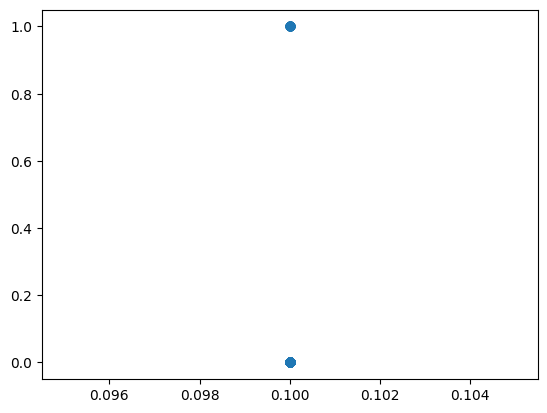

In [ ]:
if name == "MNIST":
    y_hat = test_start_batch[:, x_size-1]
    y = test_target_batch[:, x_size-1]
    plt.scatter(y_hat, y)

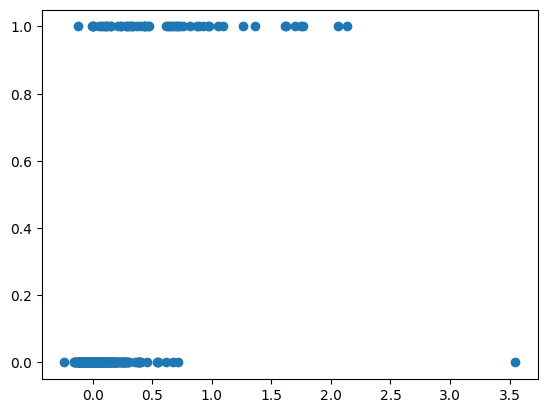

In [ ]:
if name == "MNIST":
    y_hat = test_mapped_batch[:, x_size-1]
    y = test_target_batch[:, x_size-1]
    plt.scatter(y_hat, y)